# Mode Summation

Mode summation is the bottleneck of this calculation. We handle this in two ways: interpolation for fast waveforms and direct summation for slow waveforms. They both have the same interface and produce the same product. They take Teukolsky modes and phases and combine that information to create the waveform.  

### Interpolated summation

To maximize efficiency we use the cubic spline discussed above to accelerate the computation with an interpolated summation (that is additionally parallelised on the GPU). This class is [InterpolatedModeSum](https://bhptoolkit.org/FastEMRIWaveforms/user/sum.html#few.summation.interpolatedmodesum.InterpolatedModeSum). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import few

# tune few configuration
cfg_set = few.get_config_setter(reset=True)

# Uncomment if you want to force CPU or GPU usage
# Leave commented to let FEW automatically select the best available hardware
#   - To force CPU usage:
# cfg_set.enable_backends("cpu")
#   - To force GPU usage with CUDA 12.x
# cfg_set.enable_backends("cuda12x", "cpu")
#   - To force GPU usage with CUDA 11.x
# cfg_set.enable_backends("cuda11x", "cpu")

cfg_set.set_log_level("info");

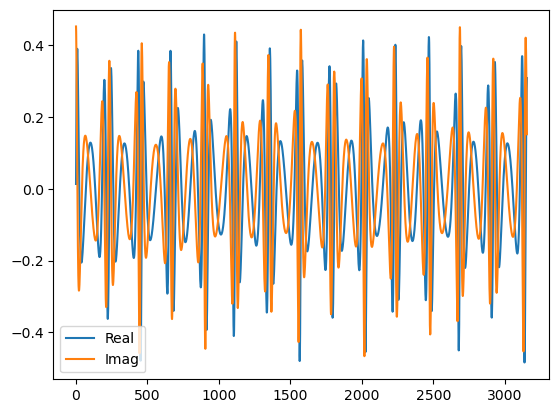

In [2]:
from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import SchwarzEccFlux
from few.amplitude.romannet import RomanAmplitude
from few.summation.interpolatedmodesum import InterpolatedModeSum
from few.utils.ylm import GetYlms
from few.utils.constants import YRSID_SI

m1 = 1e6                # primary mass (solar masses)
m2 = 1e1                # secondary mass (solar masses)
p0 = 12.0               # initial (dimensionless) semi-latus rectum
e0 = 0.4                # initial eccentricity
theta = np.pi / 5.0     # CHECK
phi = np.pi / 3.0       # CHECK
T = 0.001               # observing time (years)
dt = 10.0               # time sampling interval (seconds)
Tsec = T * YRSID_SI     # observing time (converted to seconds)

traj = EMRIInspiral(func=SchwarzEccFlux)
amp = RomanAmplitude()
interpolate_mode_sum = InterpolatedModeSum()
ylm_gen = GetYlms(include_minus_m=False)

# very simplified waveform example

# Schwarzschild
a = 0.0
xI0 = 1.0

# get trajectory
(t, p, e, x, Phi_phi, Phi_theta, Phi_r) = traj(m1, m2, a, p0, e0, xI0, T=T, dt=dt)

ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[amp.inverse_lm]

# get amplitudes
teuk_modes = amp(a, p, e, x, amp.l_arr, amp.m_arr, amp.k_arr, amp.n_arr)

# need to prepare arrays for sum with all modes due to +/- m setup
ls = amp.l_arr[: teuk_modes.shape[1]]
ms = amp.m_arr[: teuk_modes.shape[1]]
ks = amp.k_arr[: teuk_modes.shape[1]]
ns = amp.n_arr[: teuk_modes.shape[1]]

keep_modes = np.arange(teuk_modes.shape[1])
temp2 = keep_modes * (keep_modes < amp.num_m0) + (keep_modes + amp.num_m_1_up) * (
    keep_modes >= amp.num_m0
) # amp.num_m0 gives number of modes with m == 0, amp.num_m_1_up gives number of modes with m > 0

ylmkeep = np.concatenate([keep_modes, temp2])
ylms_in = ylms[ylmkeep]
teuk_modes_in = teuk_modes

# perform summation
waveform1 = interpolate_mode_sum(
    t,
    teuk_modes_in,
    ylms_in,
    traj.integrator_spline_t,
    traj.integrator_spline_phase_coeff,
    ls,
    ms,
    ks,
    ns,
    dt=dt,
    T=T,
)

plt.plot(waveform1.real, label="Real")
plt.plot(waveform1.imag, label="Imag")
plt.legend(loc="lower left")

### Direct summation

For the direct mode summation, [DirectModeSum](https://bhptoolkit.org/FastEMRIWaveforms/user/sum.html#few.summation.directmodesum.DirectModeSum), we are summing up all modes at each time step directly. So, no interpolation. However, in this example, we will use interpolation up front because we need  amplitude and phase arrays at all time steps for the direct mode sum because the direct mode sum will not fill in time steps like the interpolated mode sum.  

In [3]:
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few.summation.directmodesum import DirectModeSum
from few.utils.utility import get_mismatch

# full time grid
t_new = np.arange(t[0], t[-1], dt)

# interpolate amplitudes onto full time grid
interp_in = np.zeros((teuk_modes.shape[1] * 2, teuk_modes.shape[0]))

interp_in[: teuk_modes.shape[1], :] = teuk_modes.T.real
interp_in[teuk_modes.shape[1] :, :] = teuk_modes.T.imag

spline = CubicSplineInterpolant(t, interp_in)

# notice the new shape is (ninterps, length) just like the inital input to the spline
temp = spline(t_new).T
teuk_modes_in = temp[:, : teuk_modes.shape[1]] + temp[:, teuk_modes.shape[1] :] * 1j

# interpolate phase arrays onto full time grid
interp_in2 = np.zeros((3, teuk_modes.shape[0]))
interp_in2[0] = Phi_phi
interp_in2[1] = Phi_theta
interp_in2[2] = Phi_r

spline2 = CubicSplineInterpolant(t, interp_in2)
Phi_phi_in, Phi_theta_in, Phi_r_in = spline2(t_new)

# perform mode summation directly
direct_mode_sum = DirectModeSum()
waveform2 = direct_mode_sum(
    t,
    teuk_modes_in,
    ylms_in,
    t,
    [Phi_phi_in, Phi_theta_in, Phi_r_in],
    amp.l_arr[: teuk_modes.shape[1]],
    amp.m_arr[: teuk_modes.shape[1]],
    amp.k_arr[: teuk_modes.shape[1]],
    amp.n_arr[: teuk_modes.shape[1]],
    dt=dt,
    T=T,
)

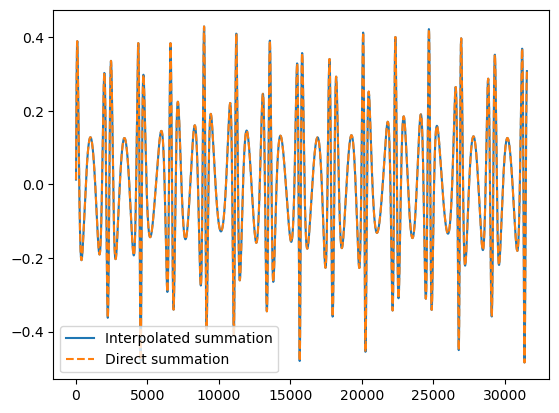

In [4]:
# comparison plot: direct vs interpolated summation
plt.plot(t_new, waveform1.real, label="Interpolated summation")
plt.plot(t_new, waveform2.real, '--', label="Direct summation")
plt.legend()

In [5]:
# compute the mismatch between the direct and interpolated mode sum waveforms:
print("Mismatch:", get_mismatch(waveform1, waveform2))

Mismatch: -2.220446049250313e-16
